## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams.update({'font.size': 14})
import seaborn as sns

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

import warnings
warnings.filterwarnings('ignore')

#import natural language toolkit
import nltk


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from scipy.stats import chisquare
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from nltk.tokenize import sent_tokenize, word_tokenize

## Importing the Required Datasets

In [4]:
inspections_filepath = 'data/data/inspections.csv'
df_inspections = pd.read_csv(inspections_filepath)

In [5]:
violations_filepath = 'data/data/violations.csv'
df_violations = pd.read_csv(violations_filepath)

In [6]:
zipcodes_filepath = 'data/data/zipcodes.csv'
df_zipcodes = pd.read_csv(zipcodes_filepath)

## Filtering out columns

In [7]:
df_inspections = df_inspections.drop(['date','name','address1','address2','city','state','phonenumber','restaurantopendate',
                     'days_from_open_date','facilitytype','type','description','inspectedby','inspection_num',
                     'inspector_id','previous_inspection_date','days_since_previous_inspection',
                     'previous_inspection_by_same_inspector', 'num_critical_previous', 'num_non_critical_previous',
                     'num_critical_mean_previous', 'num_non_critical_mean_previous', 'avg_neighbor_num_critical', 
                     'avg_neighbor_num_non_critical', 'top_match', 'second_match', 'critical'], axis = 1)

In [8]:
df_inspections.head()

,hsisid,postalcode,x,y,geocodestatus,zip,score,num_critical,num_non_critical
0,4092013748,27610,-78.587963,35.783914,M,27610,96.0,9,7
1,4092014046,27610,-78.549673,35.791986,M,27610,98.0,0,11
2,4092015191,27610,-78.547960,35.723125,M,27610,97.0,4,8
3,4092016122,27513,-78.815727,35.799249,M,27513,99.0,2,3
4,4092021513,27597,-78.296347,35.831285,M,27597,97.0,2,4


In [9]:
df_violations = df_violations.drop(['X.objectid', 'inspectdate', 'category', 'statecode', 'questionno', 'violationcode', 'severity',
                    'shortdesc', 'inspectedby', 'pointvalue', 'observationtype', 'violationtype', 'count',
                    'cdcdataitem'], axis = 1)

In [10]:
df_zipcodes.head()

,zip,median_family_income_dollars,median_household_income_dollars,per_capita_income_dollars,percent_damilies_below_poverty_line,percent_snap_benefits,percent_supplemental_security_income,percent_nonwhite
0,27501,59408,51121,21631,10.5,15.5,5.2,17.9
1,27502,109891,95857,36763,3.4,2.4,0.8,18.9
2,27511,82292,67392,33139,9.6,4.5,2.2,24.8
3,27513,109736,87262,41232,3.8,2.4,1.5,27.8
4,27518,125432,98247,49865,5.5,1.0,1.7,19.9


## Merging Datasets for Socio-Economic Status

In [11]:
df = pd.merge(df_violations, df_inspections, on = 'hsisid')

In [12]:
df_v = pd.merge(df, df_zipcodes, on = 'zip')
df_v.head()

,hsisid,critical,comments,cdcriskfactor,postalcode,x,y,geocodestatus,zip,score,num_critical,num_non_critical,median_family_income_dollars,median_household_income_dollars,per_capita_income_dollars,percent_damilies_below_poverty_line,percent_snap_benefits,percent_supplemental_security_income,percent_nonwhite
0,4092013840,Yes,7-102.11; Priority Foundation - Found unlabele...,NaN,27513,-78.771157,35.826999,M,27513,98.5,0,6,109736,87262,41232,3.8,2.4,1.5,27.8
1,4092013840,Yes,7-102.11; Priority Foundation - Found unlabele...,NaN,27513,-78.771157,35.826999,M,27513,96.5,4,13,109736,87262,41232,3.8,2.4,1.5,27.8
2,4092013840,Yes,7-102.11; Priority Foundation - Found unlabele...,NaN,27513,-78.771157,35.826999,M,27513,97.0,6,10,109736,87262,41232,3.8,2.4,1.5,27.8
3,4092013840,Yes,7-102.11; Priority Foundation - Found unlabele...,NaN,27513,-78.771157,35.826999,M,27513,96.5,5,7,109736,87262,41232,3.8,2.4,1.5,27.8
4,4092013840,Yes,7-102.11; Priority Foundation - Found unlabele...,NaN,27513,-78.771157,35.826999,M,27513,94.5,6,11,109736,87262,41232,3.8,2.4,1.5,27.8


In [13]:
df_i = pd.merge(df_inspections, df_zipcodes, on = 'zip')

**Dividing the income per capita into two equal groups, high and low**

In [14]:
med_income = df_zipcodes['per_capita_income_dollars'].median()

In [15]:
def high_low(income):
    if income <= med_income:
        return 'Low'
    else:
        return 'High'

In [16]:
df_i['income_category'] = df_i['per_capita_income_dollars'].apply(high_low)

In [17]:
df_zipcodes['income_category'] = df_zipcodes['per_capita_income_dollars'].apply(high_low)

In [47]:
df_v['income_category'] = df_v['per_capita_income_dollars'].apply(high_low)

**Checking to see whether there are any differences between inspection rates for higher vs lower income areas**

In [52]:
high_rest = len(df_i[df_i['income_category'] == 'High']['hsisid'].unique())
print('The number of restaurants in higher income areas:', high_rest)

low_rest = len(df_i[df_i['income_category'] == 'Low']['hsisid'].unique())
print('The number of restaurants in lower income areas:', low_rest)

inspection_counts = df_i['income_category'].value_counts()
print('\n''Inspection count in higher income areas:', inspection_counts[0])
print('Inspection count in lower income areas:', inspection_counts[1])

inspection_rate = [inspection_counts[0]/high_rest, inspection_counts[1]/low_rest]
print('\n''Inspections per restaurant in higher income areas:', inspection_rate[0])
print('Inspections per restaurant in lower income areas:', inspection_rate[1])

violation_counts = df_v['income_category'].value_counts()
print('\n''Violation count in higher income areas:', violation_counts[0])
print('Violation count in lower income areas:', violation_counts[1])

violation_rate = [violation_counts[0]/inspection_counts[0]/high_rest, violation_counts[1]/inspection_counts[1]/low_rest]
print('\n''Violations per restaurant in higher income areas:', violation_rate[0])
print('Violations per restaurant in lower income areas:', violation_rate[1])

The number of restaurants in higher income areas: 1732
The number of restaurants in lower income areas: 1267

Inspection count in higher income areas: 10317
Inspection count in lower income areas: 7914

Inspections per restaurant in higher income areas: 5.956697459584295
Inspections per restaurant in lower income areas: 6.246250986582479

Violation count in higher income areas: 614394
Violation count in lower income areas: 476894

Violations per restaurant in higher income areas: 0.03438314886907212
Violations per restaurant in lower income areas: 0.04756080509518364


**As the p-value (shown below) is greater than 0.01, the difference between inspection rates of higher and lower income areas is not significant**

In [53]:
chisquare([inspection_rate[0],inspection_rate[1]])

Power_divergenceResult(statistic=0.006870572744525872, pvalue=0.933939865788918)

In [54]:
chisquare([violation_rate[0],violation_rate[1]])

Power_divergenceResult(statistic=0.0021191389384178695, pvalue=0.9632830658564305)

**The following shows the means of different variables grouped by the income category. This was mainly done to see whether there are any differences between scores given to restaurants in higher and lower income areas**

In [20]:
df_i.groupby(['income_category']).mean()

,hsisid,x,y,zip,score,num_critical,num_non_critical,median_family_income_dollars,median_household_income_dollars,per_capita_income_dollars,percent_damilies_below_poverty_line,percent_snap_benefits,percent_supplemental_security_income,percent_nonwhite
income_category,,,,,,,,,,,,,,
High,4.092036e+09,-78.719002,35.827265,27566.955316,96.247746,2.943879,5.179510,99647.649123,78875.429195,40430.563827,5.280789,4.357507,1.806862,24.717718
Low,4.092044e+09,-78.616345,35.771435,27588.858731,96.190296,2.734521,5.184736,62759.464367,52140.142911,24575.988249,14.291180,12.309578,4.653791,40.244364


# Text Analysis of Violation Comments

In [21]:
df_violations.head()

,hsisid,critical,comments,cdcriskfactor
0,4092015279,Yes,7-102.11; Priority Foundation - Found unlabele...,NaN
1,4092014572,Yes,7-102.11; Priority Foundation; One sanitizer b...,NaN
2,4092015906,Yes,7-102.11; Priority Foundation - Found an unlab...,NaN
3,4092013840,Yes,7-102.11; Priority Foundation - Found unlabele...,NaN
4,4092021788,Yes,7-102.11; Priority Foundation - Found one unla...,NaN


## Removing rows with no comments

In [22]:
check_comment = df_violations[df_violations['comments'].isnull()]
check_comment.shape

(448, 4)

In [23]:
df_c = df_violations.dropna()

**Most of the comments have numbers in them. To avoid the numbers influencing the text analysis, all digits were removed from the comments**

In [24]:
df_c['comments'] = df_c['comments'].str.replace('\d+', '')

**The function below finds the frequency of a word in comments for critical vs non-critical violations**

In [25]:
def check_word_freq(df, word):
    
    critical = df[df['critical'] == 'Yes']['comments'].str.lower().str.contains(word).sum()/df[df['critical'] == 'Yes']['comments'].notnull().sum()
    non_critical = df[df['critical'] == 'No']['comments'].str.lower().str.contains(word).sum()/df[df['critical'] == 'No']['comments'].notnull().sum()
    
    out = pd.DataFrame({'critical_freq': [critical], 'non_critical_freq': [non_critical]})
    return out

In [26]:
check_word_freq(df_c, 'sanitizer')

,critical_freq,non_critical_freq
0,0.008332,0.003299


### The next set of code is for cleaning the comments for punctuations, stop-words, etc.

In [27]:
df_c['comments_token'] = df_c['comments'].apply(word_tokenize) 
df_c.head()

,hsisid,critical,comments,cdcriskfactor,comments_token
1449,4092016281,Yes,-.; Priority Foundation; Unopened packaged ki...,Food from Unsafe Source,"[-, ., ;, Priority, Foundation, ;, Unopened, p..."
1450,4092019999,Yes,Violation Codes\r\n(A) Fish that are received ...,Food from Unsafe Source,"[Violation, Codes, (, A, ), Fish, that, are, r..."
1451,4092019999,Yes,Violation Codes\r\n(A) Fish that are received ...,Food from Unsafe Source,"[Violation, Codes, (, A, ), Fish, that, are, r..."
1452,4092016029,Yes,-.; Priority; There was only one invoice on ha...,Food from Unsafe Source,"[-, ., ;, Priority, ;, There, was, only, one, ..."
1454,4092050011,Yes,P - -. - Chic-fil-A chicken nuggets were deliv...,Food from Unsafe Source,"[P, -, -, ., -, Chic-fil-A, chicken, nuggets, ..."


In [28]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
df_c['comments_stop'] = df_c['comments_token'].apply(lambda x: [item for item in x if item not in stop_words])

In [30]:
df_c.head()

,hsisid,critical,comments,cdcriskfactor,comments_token,comments_stop
1449,4092016281,Yes,-.; Priority Foundation; Unopened packaged ki...,Food from Unsafe Source,"[-, ., ;, Priority, Foundation, ;, Unopened, p...","[-, ., ;, Priority, Foundation, ;, Unopened, p..."
1450,4092019999,Yes,Violation Codes\r\n(A) Fish that are received ...,Food from Unsafe Source,"[Violation, Codes, (, A, ), Fish, that, are, r...","[Violation, Codes, (, A, ), Fish, received, sa..."
1451,4092019999,Yes,Violation Codes\r\n(A) Fish that are received ...,Food from Unsafe Source,"[Violation, Codes, (, A, ), Fish, that, are, r...","[Violation, Codes, (, A, ), Fish, received, sa..."
1452,4092016029,Yes,-.; Priority; There was only one invoice on ha...,Food from Unsafe Source,"[-, ., ;, Priority, ;, There, was, only, one, ...","[-, ., ;, Priority, ;, There, one, invoice, ha..."
1454,4092050011,Yes,P - -. - Chic-fil-A chicken nuggets were deliv...,Food from Unsafe Source,"[P, -, -, ., -, Chic-fil-A, chicken, nuggets, ...","[P, -, -, ., -, Chic-fil-A, chicken, nuggets, ..."


In [31]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [32]:
df_c['comments_stem'] = df_c['comments_stop'].apply(lambda x: [ps.stem(y) for y in x])

In [33]:
comments_critical = df_c[df_c['critical'] == 'Yes']['comments_stem'].apply(pd.Series).stack()

In [34]:
comments_non_critical = df_c[df_c['critical'] == 'No']['comments_stem'].apply(pd.Series).stack()

**Figuring out the frequency distribution of the words used in comments for critical vs non-critical violatons**

In [35]:
from nltk.probability import FreqDist
import string

# calculation word frequency
fdist_comments_critical = FreqDist(comments_critical)
fdist_comments_non_critical = FreqDist(comments_non_critical)

In [36]:
for punc in string.punctuation:
    del fdist_comments_critical[punc]
    del fdist_comments_non_critical[punc]

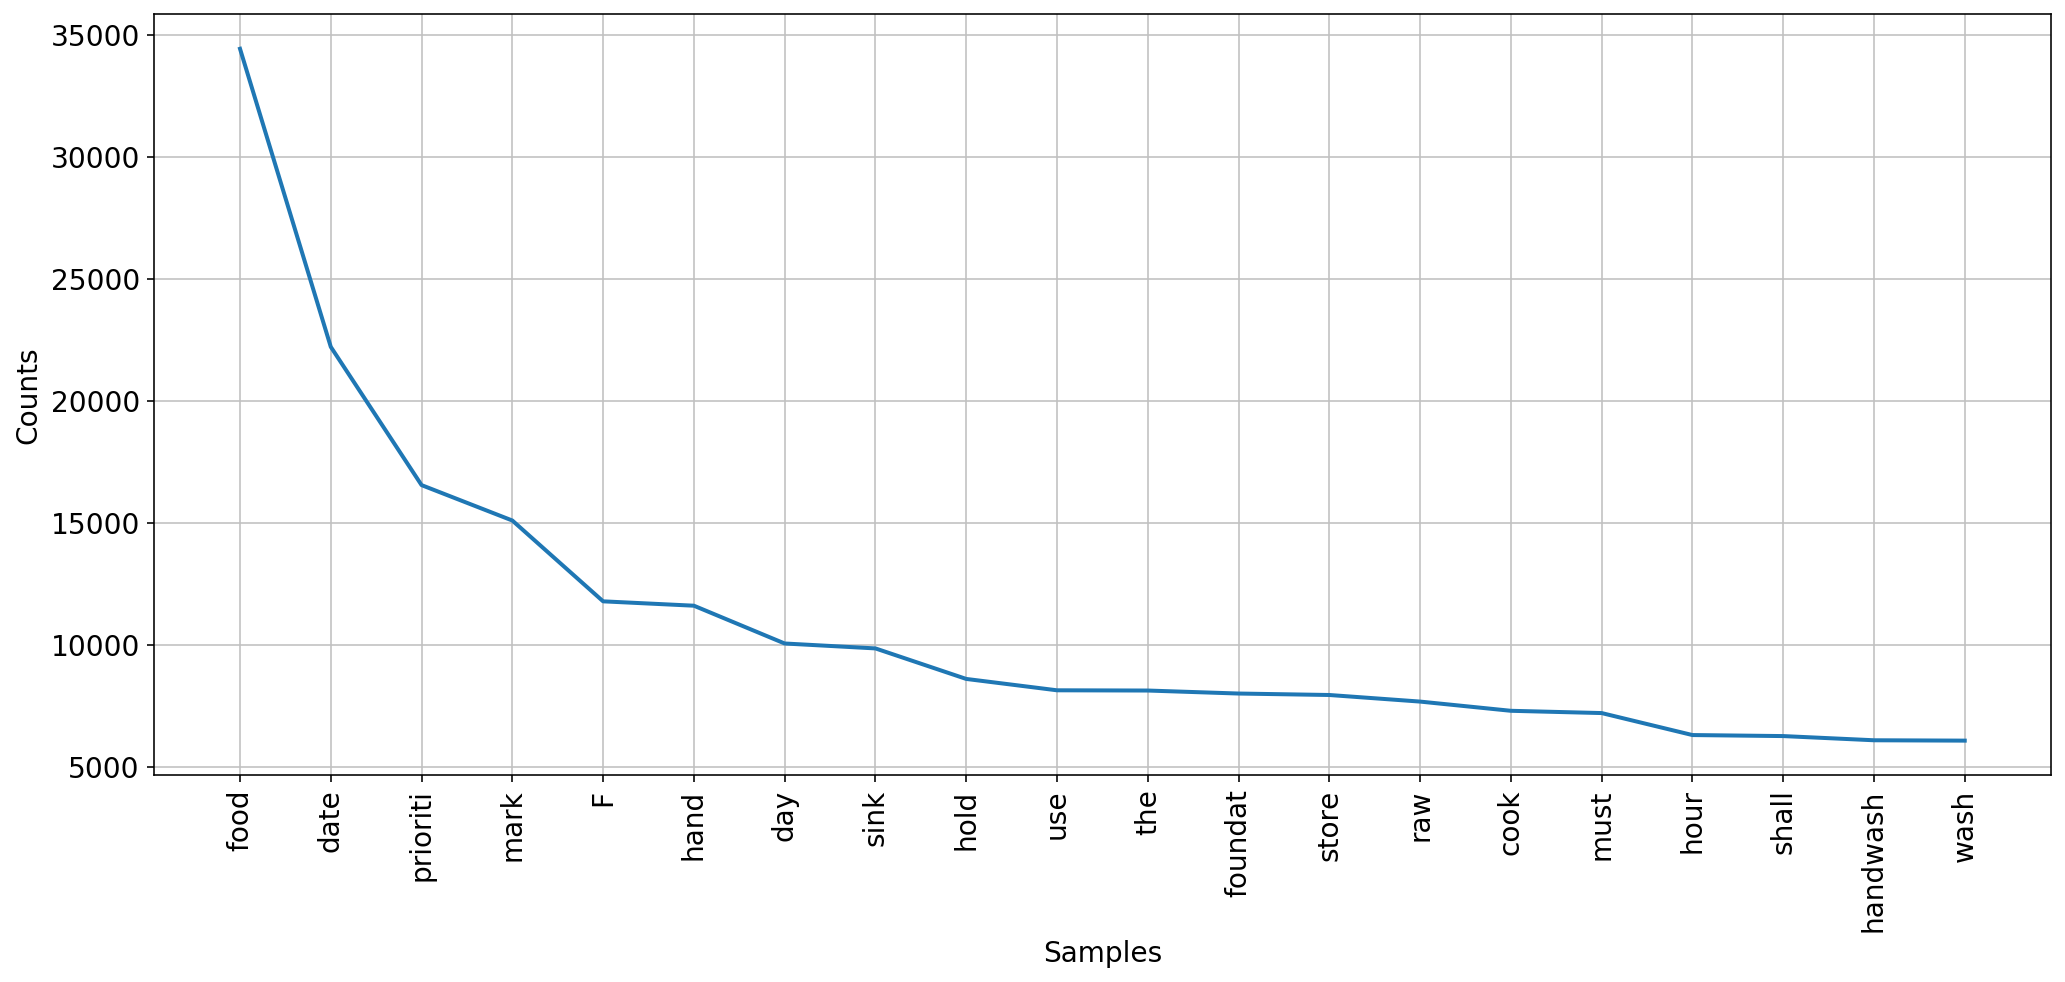

In [37]:
fdist_comments_critical.plot(20, cumulative=False)

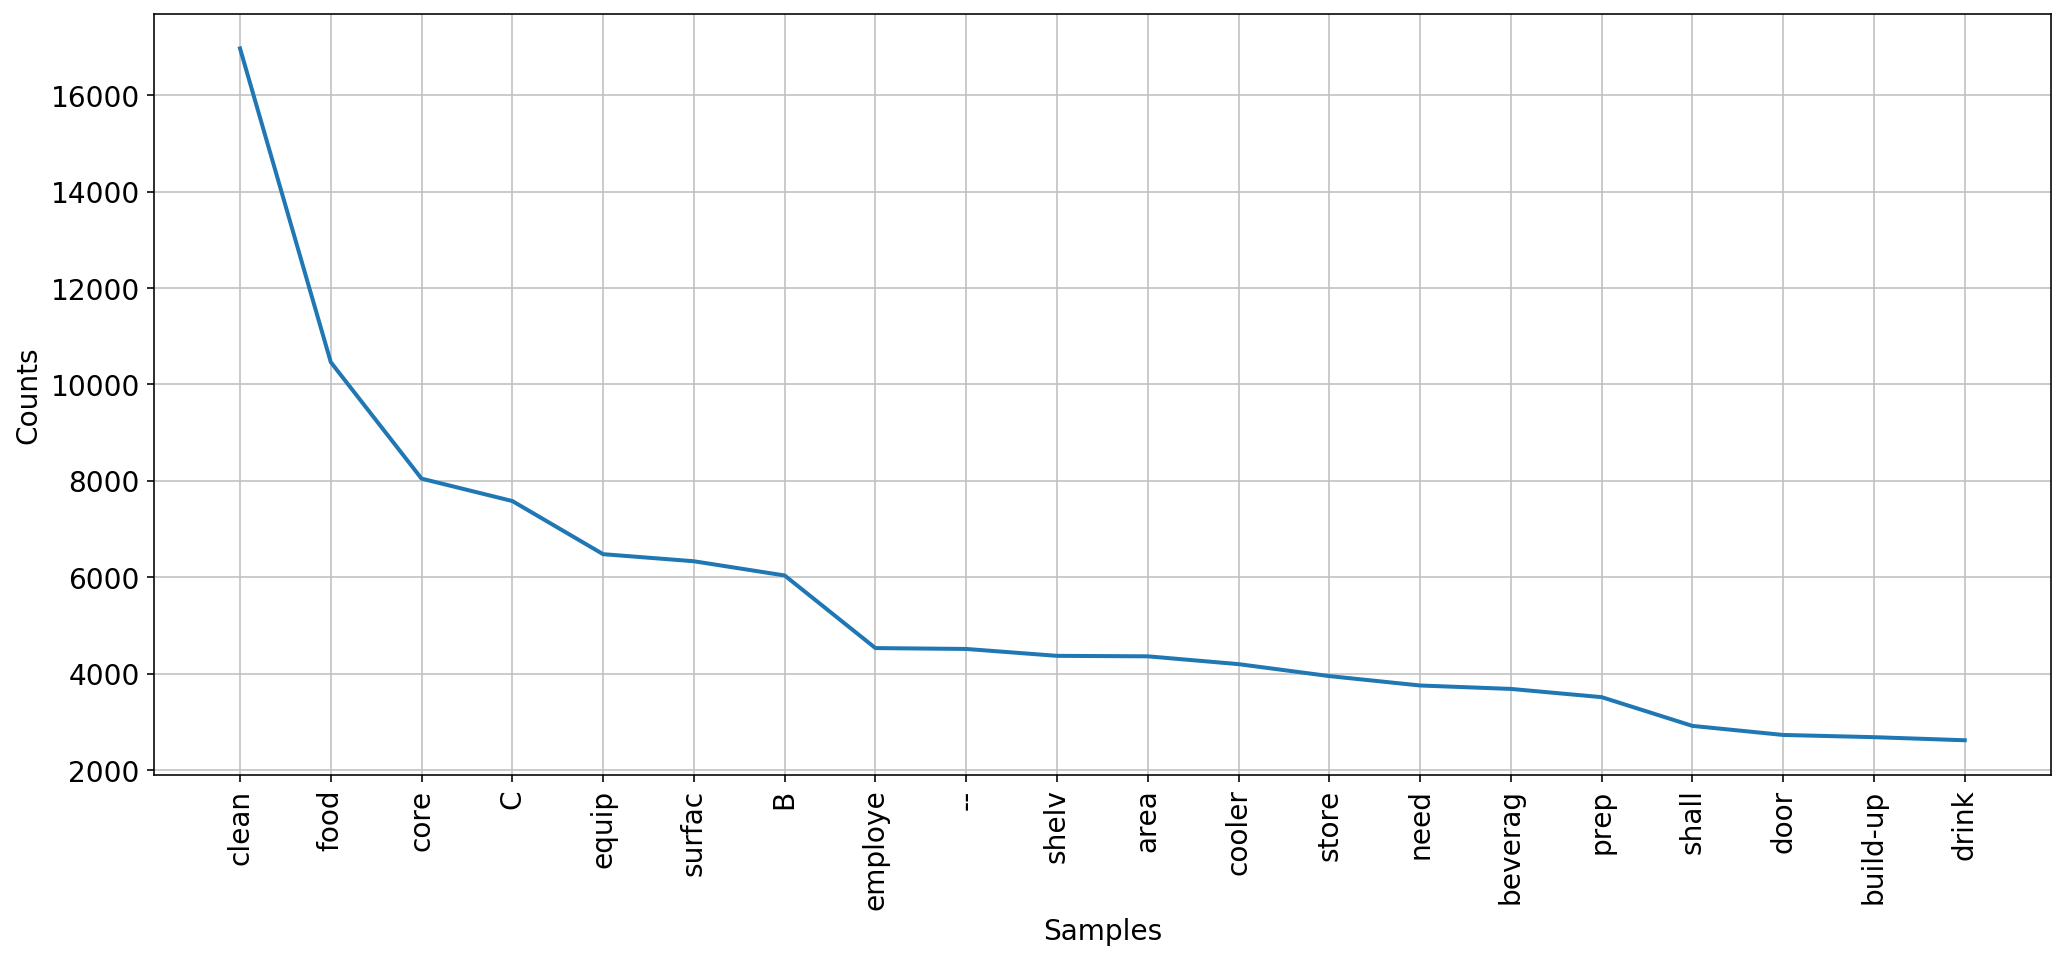

In [38]:
fdist_comments_non_critical.plot(20, cumulative=False)

### The code above looked at the raw frequencies, the following set of code weighs unique things to help compare critical vs non-critical comments

In [39]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=2000,
                        tokenizer=word_tokenize,
                        stop_words=stop_words)

In [40]:
critical_list = list(df_c[df_c['critical'] == 'Yes']['comments'].values)
non_critical_list = list(df_c[df_c['critical'] == 'No']['comments'].values)

In [41]:
import string 

# lowercase text
critical = list(map(str.lower, critical_list))
non_critical = list(map(str.lower, non_critical_list))

# remove punctuation
for c in string.punctuation:
    critical = str(critical).replace(c, "")
    non_critical = str(non_critical).replace(c, "")

# get list of two documents together
corpus = [str(critical), str(non_critical)]

In [42]:
comments_tfidf = pd.DataFrame(tfidf.fit_transform(corpus).toarray())
comments_tfidf.columns = tfidf.get_feature_names()
comments_tfidf = comments_tfidf.rename(index={0:'critical', 1:'non_critical'})

In [43]:
most_unique = comments_tfidf.idxmax(axis=1) 
most_unique

critical                   rte
non_critical    nonfoodcontact
dtype: object

In [45]:
comments_tfidf.sort_values(by='critical', axis=1, ascending=False)

,rte,foods,date,priority,f,food,recorded,tphc,maximum,marked,...,exhaust,extensions,wooden,hoods,slats,fixtures,cupboards,gritty,flume,backsidesundersides
critical,0.046651,0.041323,0.041018,0.040249,0.040160,0.039198,0.038921,0.038438,0.037715,0.037595,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
non_critical,0.000000,0.041375,0.027478,0.022552,0.021934,0.053263,0.000000,0.000000,0.000000,0.021233,...,0.036388,0.034217,0.033397,0.034596,0.038402,0.043786,0.034956,0.046246,0.031696,0.036242


In [46]:
comments_tfidf.sort_values(by='non_critical', axis=1, ascending=False)

,nonfoodcontact,clean,encrusted,accumulations,food,core,c,equipment,b,surfaces,...,ensuring,tagged,allowable,ricotta,enter,intermingled,integrity,intact,roasts,showed
critical,0.000000,0.031905,0.000000,0.000000,0.039198,0.016542,0.027115,0.034633,0.029253,0.027608,...,0.025506,0.027413,0.023752,0.02515,0.023249,0.024899,0.025731,0.027168,0.028018,0.022884
non_critical,0.060039,0.054672,0.054601,0.053563,0.053263,0.052423,0.052035,0.051197,0.050962,0.050903,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
